In [ ]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from transformers import logging
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image

import torchvision.transforms as T

from torchinfo import summary

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()
dev = "cuda"

In [ ]:
from lovely_tensors import monkey_patch
monkey_patch()

In [ ]:
def sigmas(x: torch.Tensor, n=3):
    u = x / (x.std()*n*2) # *2 because I want +/- n sigmas
    return (u - u.mean() + 0.5) #.clip(0,1)

In [ ]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae.requires_grad_(False).to(dev);

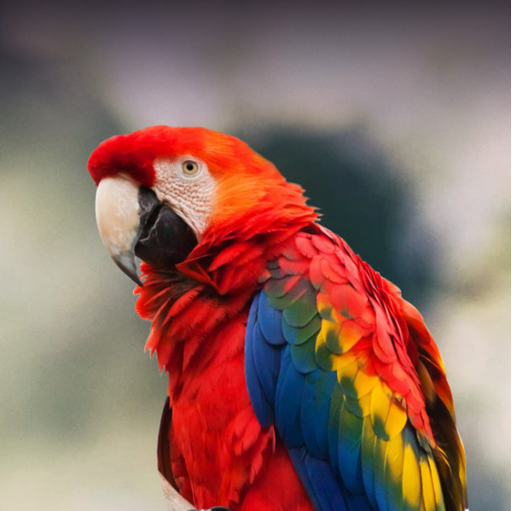

In [ ]:
img = T.ToTensor()(Image.open('macaw.jpg').resize((512, 512))).to(dev)
img.rgb

In [ ]:
img

tensor[3, 512, 512] n=786432 x∈[0., 1.000] μ=0.451 σ=0.254 cuda:0

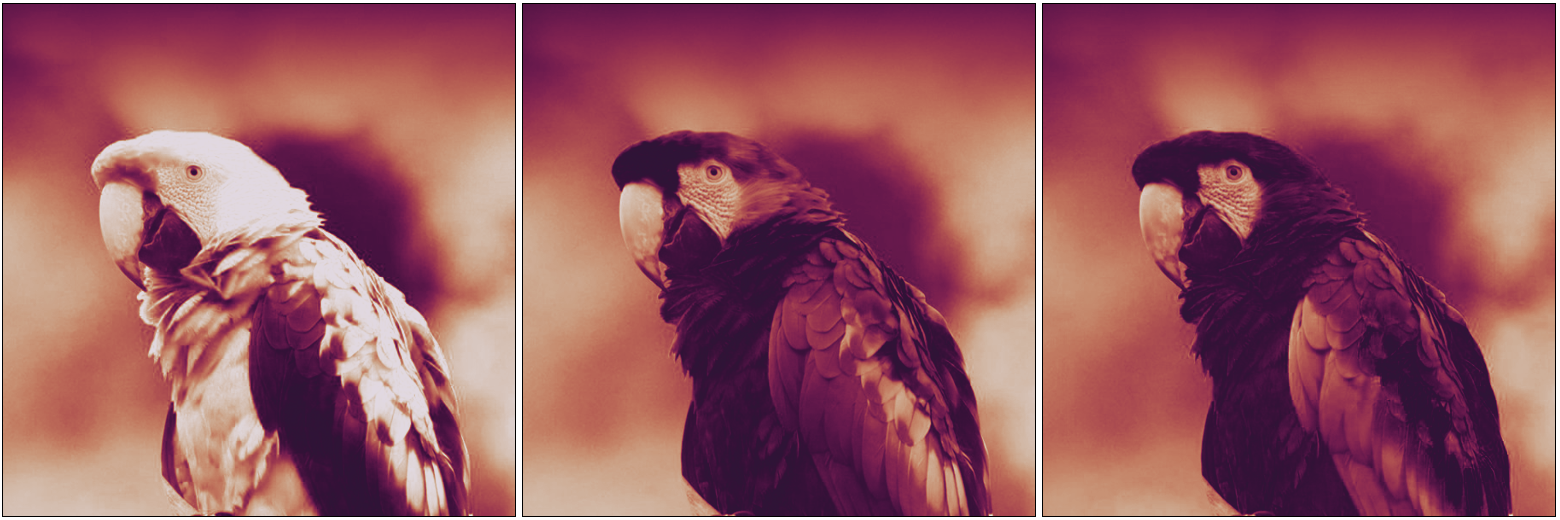

In [ ]:
img.chans(view_width=3000)

In [ ]:
latent = vae.encode(img[None]*2-1).latent_dist.sample()
latent

tensor[1, 4, 64, 64] n=16384 x∈[-49.162, 36.679] μ=0.482 σ=5.105 cuda:0

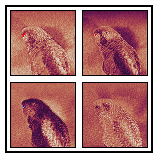

In [ ]:
sigmas(latent).chans(scale=1)

In [ ]:
decoded_image = (vae.decode(latent).sample/2+0.5).clip(0,1)
decoded_image

tensor[1, 3, 512, 512] n=786432 x∈[0., 1.000] μ=0.445 σ=0.253 cuda:0

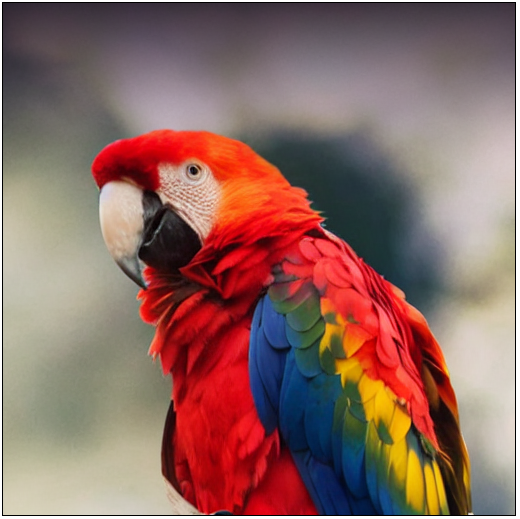

In [ ]:
decoded_image.rgb

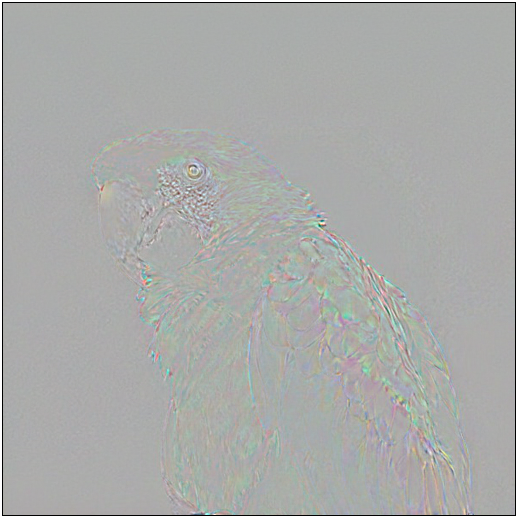

In [ ]:
diff = img - decoded_image
diff -= diff.min()
diff.rgb

In [ ]:
def vae_encode_img(x):
    return vae.encode(x[None]*2-1).latent_dist.sample()*0.18215

def vae_decode_img(x):
    return (vae.decode(x/0.18215).sample/2+0.5).clip(0,1)

In [ ]:
# vae_decode_img(vae_encode_img(img)).rgb

In [ ]:
# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
text_encoder.requires_grad_(False).to(dev);

In [ ]:
prompt = "My cute cat"
tokenizer(prompt, return_tensors="pt").input_ids.p

tensor([[49406,   607,  2242,  2368, 49407]])

In [ ]:
prompt = "My cute dog"
tokenizer(prompt, return_tensors="pt").input_ids.p

tensor([[49406,   607,  2242,  1929, 49407]])

In [ ]:
prompt = "My cute armadillo"
tokenizer(prompt, return_tensors="pt").input_ids.p

tensor([[49406,   607,  2242, 37897,  7588, 49407]])

In [ ]:
len(tokenizer.get_vocab())

49408

In [ ]:
prompt = "A photo of pasta on a plate"
tokenizer(prompt, return_tensors="pt").input_ids.p

tensor([[49406,   320,  1125,   539, 10441,   525,   320,  5135, 49407]])

In [ ]:
tokens = tokenizer([prompt, ""],
                    padding="max_length",
                    max_length=77,
                    return_tensors="pt").input_ids.to(dev)
tokens.v

tensor[2, 77] i64 n=154 x∈[320, 49407] μ=4.728e+04 σ=9.805e+03 cuda:0
tensor([[49406,   320,  1125,   539, 10441,   525,   320,  5135, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407],
        [49406, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
  

In [ ]:
embeddings = text_encoder(tokens).last_hidden_state
embeddings

tensor[2, 77, 768] n=118272 x∈[-28.091, 33.063] μ=-0.111 σ=1.031 cuda:0

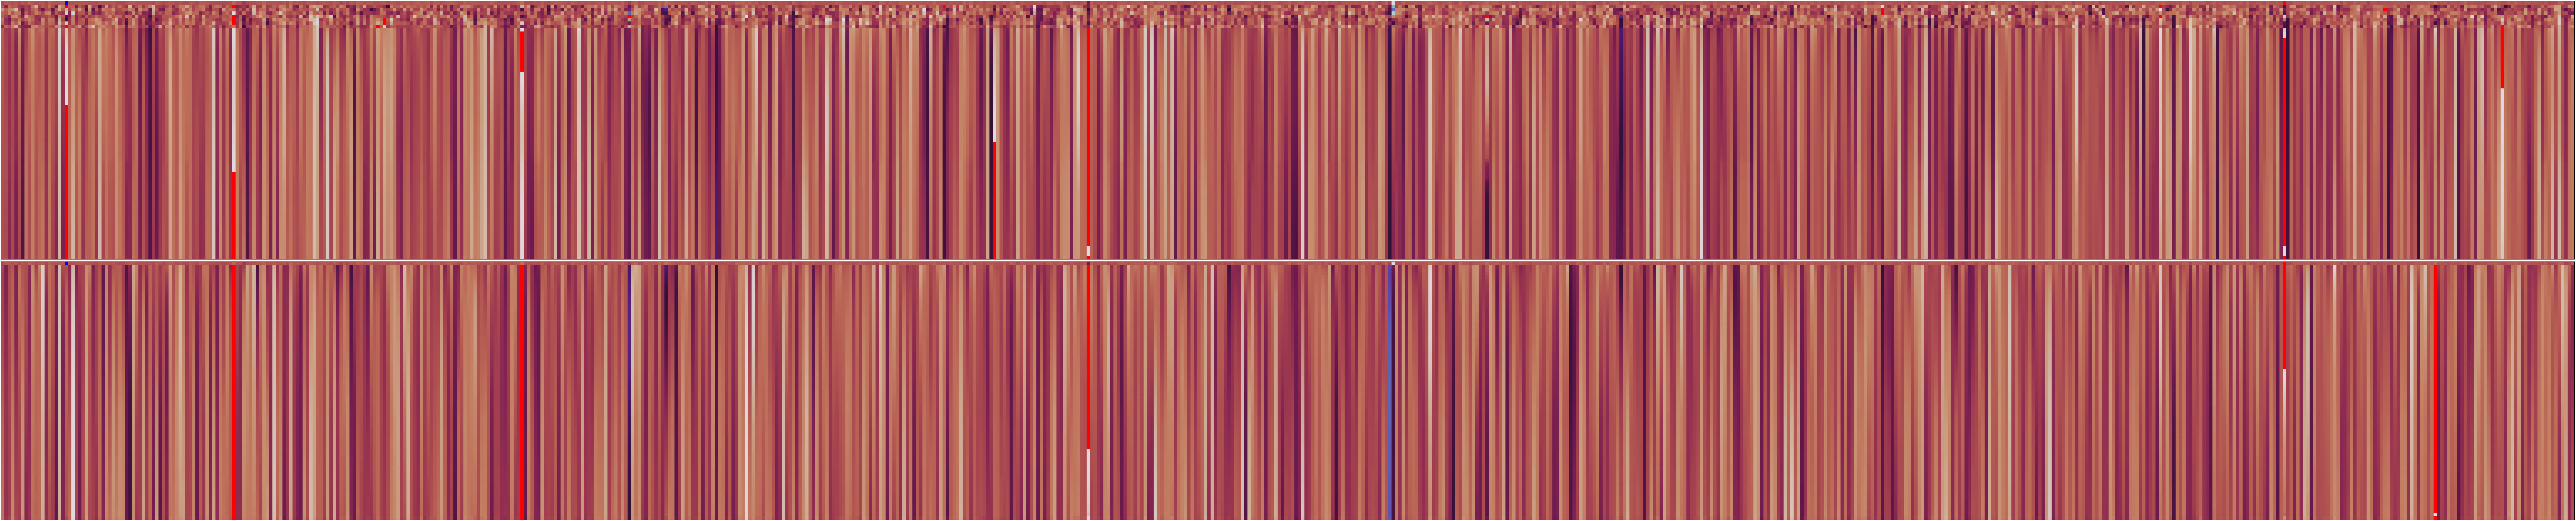

In [ ]:
sigmas(embeddings).chans(scale=10)

In [ ]:
# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
unet.requires_grad_(False).to(dev)
# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

generator = torch.manual_seed(32)
scheduler.set_timesteps(50)

In [ ]:
generator = torch.manual_seed(32)

ln = torch.randn((1, 4, 64, 64), generator=generator).to(dev)
ln *= scheduler.init_noise_sigma
ln[0,:,:32,:32] *= 2
ln

tensor[1, 4, 64, 64] n=16384 x∈[-103.913, 100.441] μ=-0.079 σ=19.277 cuda:0

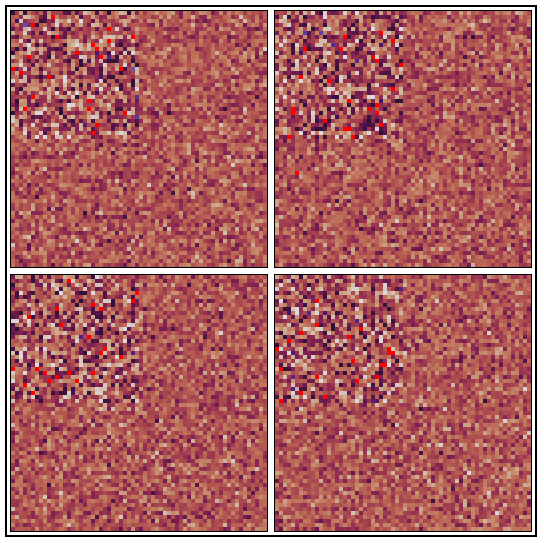

In [ ]:
sigmas(ln).chans(scale=4)

In [ ]:
ln

tensor[1, 4, 64, 64] n=16384 x∈[-103.913, 100.441] μ=-0.079 σ=19.277 cuda:0

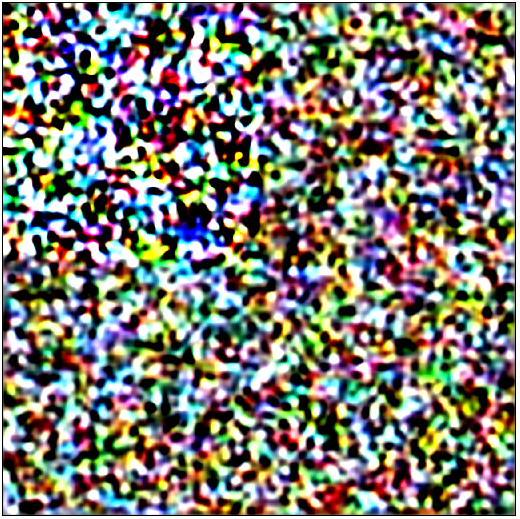

In [ ]:
vae_decode_img(ln).rgb

In [ ]:
scheduler.timesteps.v

tensor[50] f64 x∈[0., 999.000] μ=499.500 σ=297.200
tensor([999.0000, 978.6122, 958.2245, 937.8367, 917.4490, 897.0612, 876.6735,
        856.2857, 835.8980, 815.5102, 795.1224, 774.7347, 754.3469, 733.9592,
        713.5714, 693.1837, 672.7959, 652.4082, 632.0204, 611.6327, 591.2449,
        570.8571, 550.4694, 530.0816, 509.6939, 489.3061, 468.9184, 448.5306,
        428.1429, 407.7551, 387.3673, 366.9796, 346.5918, 326.2041, 305.8163,
        285.4286, 265.0408, 244.6531, 224.2653, 203.8776, 183.4898, 163.1020,
        142.7143, 122.3265, 101.9388,  81.5510,  61.1633,  40.7755,  20.3878,
          0.0000], dtype=torch.float64)

In [ ]:
t = scheduler.timesteps[0]

scaled_ln = scheduler.scale_model_input(torch.cat([ln]*2), t)

In [ ]:
preds = unet(scaled_ln, t, encoder_hidden_states=embeddings).sample

In [ ]:
preds

tensor[2, 4, 64, 64] n=32768 x∈[-6.464, 6.278] μ=-0.002 σ=1.220 cuda:0

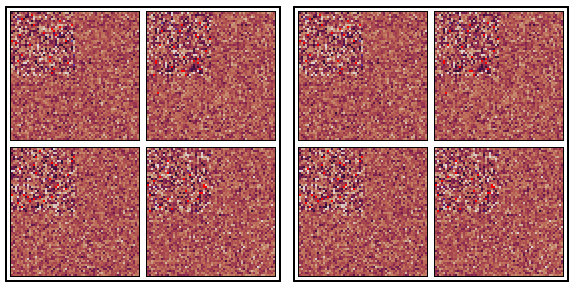

In [ ]:
sigmas(preds).chans(scale=2)

In [ ]:
P, U = preds.chunk(2)
noise_pred = U + 8 * (P - U)

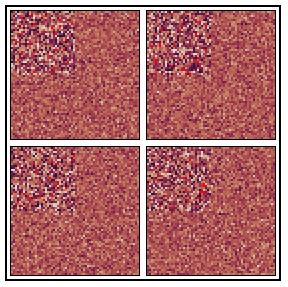

In [ ]:
sigmas(noise_pred).chans(scale=2)

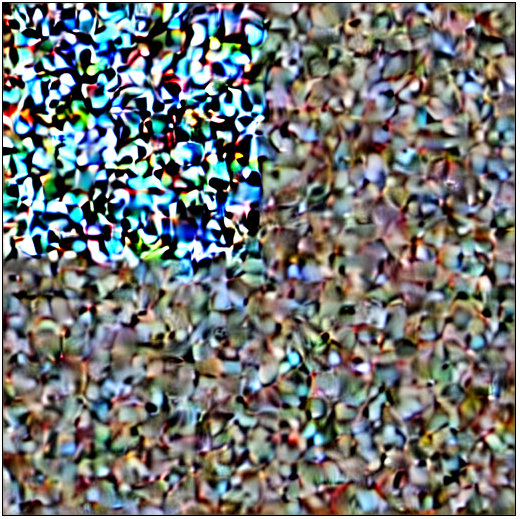

In [ ]:
vae_decode_img(noise_pred).rgb

In [ ]:
ln = scheduler.step(noise_pred, t, ln).prev_sample

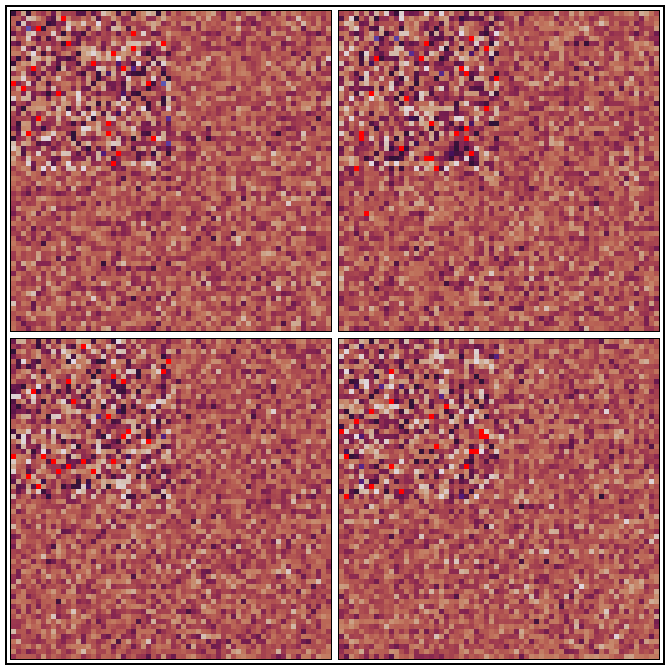

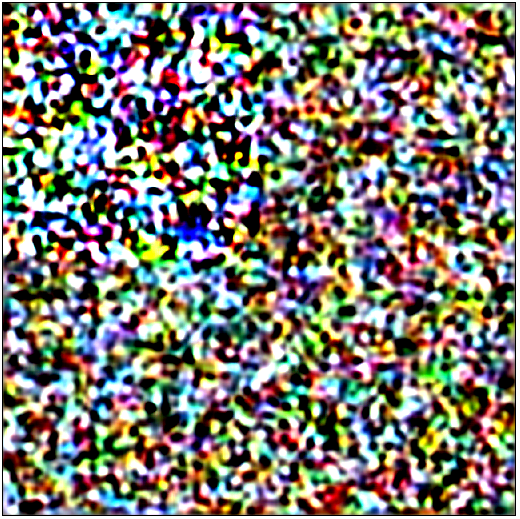

In [ ]:
display(sigmas(ln).chans(scale=5))
display(vae_decode_img(ln).rgb)

In [ ]:
generator = torch.manual_seed(32)
ln = torch.randn((1, 4, 64, 64), generator=generator).to(dev)
ln = torch.randn((1, 4, 64, 64), generator=generator).to(dev)
ln[0,:,32,:] =0

ln *= scheduler.init_noise_sigma
ln

tensor[1, 4, 64, 64] n=16384 x∈[-64.910, 58.637] μ=-0.051 σ=14.546 cuda:0

In [ ]:
saved_imgs = []

for i, t in tqdm(enumerate(scheduler.timesteps)):
    scaled_ln = scheduler.scale_model_input(torch.cat([ln]*2), t)
    
    preds = unet(scaled_ln, t, encoder_hidden_states=embeddings).sample
    
    P, U = preds.chunk(2)
    noise_pred = U + 8 * (P - U)
    
    
    ln = scheduler.step(noise_pred, t, ln).prev_sample
    saved_imgs.append(torch.cat([vae_decode_img(noise_pred), vae_decode_img(ln)], axis=-1).rgb)

0it [00:00, ?it/s]

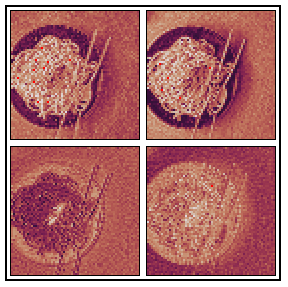

In [ ]:
sigmas(ln).chans(scale=2)

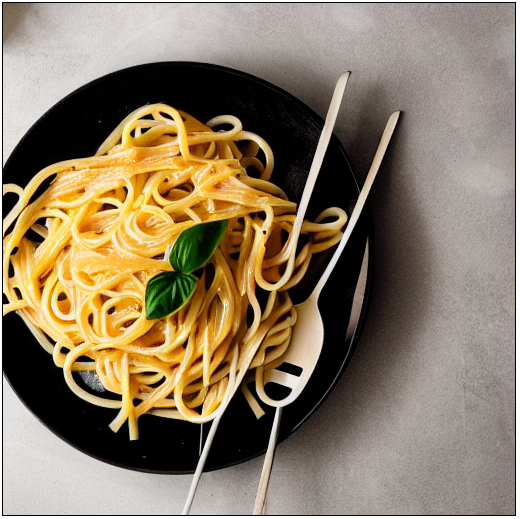

In [ ]:
vae_decode_img(ln).rgb

In [ ]:
# for img in saved_imgs[::1]:
#     display(img)